In [1]:
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

# Visualize the datasets and manage the dataset

In [2]:
edges = pd.read_csv("wikigraph_reduced.csv", sep="\t", usecols = ["0", "1"])
edges.columns = ["source", "dest"]
edges.head()

,source,dest
0,95,1185516
1,108,1059989
2,108,1062426
3,108,1161925
4,134,541222


Read each line of the "wiki-topcats-categories.txt" and create the dataset

In [3]:
categories = pd.read_csv("wiki-topcats-categories.txt", sep=";", names = ["Category", "Pages List"])
categories["Category"] = categories.Category.apply(lambda x: x[9:])
categories["Pages List"] = categories["Pages List"].apply(lambda x: x.split())
categories

,Category,Pages List
0,Buprestoidea,"[301, 302, 303, 304, 305, 306, 307, 308, 309, ..."
1,People_from_Worcester,"[1056, 1057, 1058, 1059, 1060, 60971, 76515, 7..."
2,Skin_conditions_resulting_from_physical_factors,"[971, 973, 1166, 1167, 1168, 1169, 1170, 1171,..."
3,Visual_kei_bands,"[1297, 1300, 1311, 1312, 1313, 1314, 1315, 131..."
4,Japanese_rock_music_groups,"[1297, 1300, 1313, 1314, 1315, 1316, 1319, 132..."
...,...,...
17359,British_science_fiction_novels,"[16110, 24545, 39814, 67923, 108629, 108630, 1..."
17360,Television_soundtracks,"[1117, 110192, 110376, 110377, 110380, 110395,..."
17361,Diptera_of_North_America,"[279, 280, 283, 31110, 31129, 31133, 31138, 31..."
17362,Diptera_of_Asia,"[279, 31129, 31133, 31134, 31135, 31136, 31137..."


You will notice that one article might belong to a single category or multiple ones. In the case of multiple appearance, you break the ties uniformly at random. Please, do it before solving any task in the homework.

In [4]:
cats = list(categories["Category"])
pages_list = list(categories["Pages List"])

create a vocabulary in order to create the clean categories without replicates.

In [5]:
nodes = {}
for i, list_pages in enumerate(pages_list):
    for node in list_pages:
        if node not in nodes:
            nodes[node] = []
        nodes[node].append(i)

Choose uniformly at random a category where the page will be belong, then create the dictionary.

In [6]:
import random

nodes2 = defaultdict(list)
for node in nodes.keys():
    cat = random.sample(nodes[node], 1)
    nodes2[cat[0]].append(node)

In [7]:
new_categories = pd.DataFrame()
new_categories['category'] = nodes2.keys()
new_categories['pages list'] = nodes2.values()

def set_category(x, categories):
    return categories.loc[x, "Category"]
    
new_categories["category"] = new_categories.category.apply(lambda x: set_category(x, categories)) # set the category not the integer value
new_categories

C:\Users\14193\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,category,pages list
0,Buprestoidea,"[301, 302, 304, 305, 306, 307, 308, 309, 310, ..."
1,Insect_families,"[303, 31472, 14955, 31215, 1696161, 624917, 14..."
2,People_from_Worcester,"[1056, 1060, 79143, 84354, 84740, 95330, 15841..."
3,"Alumni_of_New_College,_Oxford","[1057, 60476, 1293387, 109626, 539254, 1048560..."
4,British_writers,"[1058, 713069, 1389658, 1464147, 56413, 166650..."
...,...,...
17353,Populated_places_in_Navarre,"[130242, 130269, 444707, 445236, 1145160, 1781..."
17354,Municipalities_in_Navarre,"[445210, 1358873, 1781138, 1781142, 1781146, 1..."
17355,Municipalities_of_South_Tyrol,"[215159, 443945, 943609, 1781498, 1781519, 178..."
17356,Redirects_from_UK_postcode_districts,"[1640637, 1640638, 1788784, 1788785]"


Create the new categories dataset

Read the pages names.

In [8]:
pages_names = pd.read_csv("wiki-topcats-page-names.txt", names=["node name"])
pages_names

pages_names['node'] = [s.split()[0] for s in list(pages_names['node name']) ]
pages_names['name'] = [' '.join(s.split()[1:]) for s in list(pages_names['node name'])]

pages_names = pages_names.set_index("node").drop('node name', axis=1)
pages_names

,name
node,
0,Chiasmal syndrome
1,Kleroterion
2,Pinakion
3,LyndonHochschildSerre spectral sequence
4,Zariski's main theorem
...,...
1791484,Noadiah Russell (Yale founder)
1791485,Cornus officinalis
1791486,Peter Grummitt


# RQ1

Build the graph G=(V, E), where V is the set of articles and E the hyperlinks among them.

In [9]:
import networkx as nx

create the graph, first we consider if the edges dataframe contents a graph directed or not..

In [10]:
def isDirected(edges):
    if len(set(list(edges['source'])).intersection(set(list(edges['dest'])))) > 0:
        return "directed"
    else:
        return "undirected"

In [11]:
if isDirected(edges) == "directed":
    G = nx.DiGraph(directed=True)
else:
    G = nx.Graph()

In [12]:
sources = list(edges['source'])
dests = list(edges['dest'])

for i in range(len(edges)):
    G.add_node(sources[i], name = pages_names.loc[str(sources[i]), 'name']) # source
    G.add_node(dests[i], name = pages_names.loc[str(dests[i]), 'name']) # dest
    
    G.add_edge(sources[i], dests[i], weight=1)

In [13]:
nx.info(G)

'Name: \nType: DiGraph\nNumber of nodes: 98343\nNumber of edges: 483094\nAverage in degree:   4.9123\nAverage out degree:   4.9123'

In [14]:
print(f"The number of nodes is: {G.number_of_nodes()} and the number of edges is: {G.number_of_edges()}")

The number of nodes is: 98343 and the number of edges is: 483094


In [15]:
if nx.is_directed(G):
    print("The Graph is directed")
else:
    print("The Graph is undirected")

The Graph is directed


for the directed graph to understand if the graph is sparse or not, we should use this formula:

$D = \frac{|E|}{|V|(|V|-1)}$

a dense graph is a graph in which the number of edges is close to the maximal number of edges.

In [16]:
# we can use also nx.density(G)
D = (G.number_of_edges())/(G.number_of_nodes()*(G.number_of_nodes()-1))
print(f"The graph density is: {D}, so the graph is sparse")

The graph density is: 4.9951571365597335e-05, so the graph is sparse


the average of link per article is.. (considering the **degree** of each node)

In [17]:
degrees = dict(G.degree())
sum(degrees.values())/float(len(G))

9.824674862471147

the result presents above include in_degree and out_degree of a graph. We can consider also the in_degree and out_degree formula. But, you could use also the native function of networkx

In [18]:
indegree = sum(dict(G.in_degree()).values())/float(len(G))
outdegree = sum(dict(G.out_degree()).values())/float(len(G))
print(f"the indegree = {indegree} and the outdegree = {outdegree}")

the indegree = 4.912337431235573 and the outdegree = 4.912337431235573


Visualize the **nodes degree distribution**

In [23]:
def degree_histogram_directed(G, in_degree=False, out_degree=False):

    nodes = G.nodes()
    if in_degree:
        in_degree = dict(G.in_degree())
        degseq=[in_degree.get(k,0) for k in nodes]
    elif out_degree:
        out_degree = dict(G.out_degree())
        degseq=[out_degree.get(k,0) for k in nodes]
    else:
        degseq=[v for k, v in G.degree()]
    dmax=max(degseq)+1
    freq= [ 0 for d in range(dmax) ]
    for d in degseq:
        freq[d] += 1
    return freq

Text(0.5, 1.0, 'Visualize the nodes degree distribution')

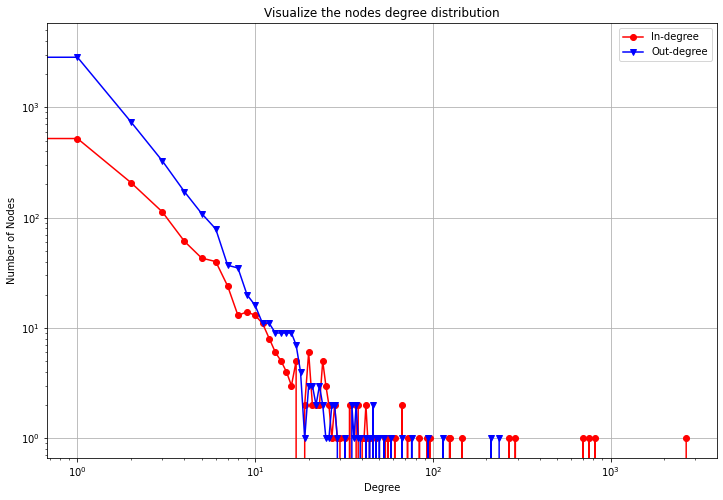

In [30]:
in_degree_freq = degree_histogram_directed(G, in_degree=True)
out_degree_freq = degree_histogram_directed(G, out_degree=True)
degrees = range(len(in_degree_freq))

plt.figure(figsize=(12, 8)) 
plt.grid(True)
plt.loglog(range(len(in_degree_freq)), in_degree_freq, 'ro-', label='in-degree') 
plt.loglog(range(len(out_degree_freq)), out_degree_freq, 'bv-', label='out-degree')
plt.legend(['In-degree','Out-degree'])
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.title('Visualize the nodes degree distribution')